In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from dataset import MNISTDataset
from model import *

from scipy.spatial.distance import cdist
from matplotlib import gridspec
import os
import cv2

from matplotlib.pyplot import imshow

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
dataset = MNISTDataset()
train_images = dataset.images_train[:20000]
test_images = dataset.images_test
len_test = len(test_images)
len_train = len(train_images)

===Loading MNIST Dataset===
Images train : (60000, 28, 28, 1)
Labels train : (60000, 1)
Images test  : (10000, 28, 28, 1)
Labels test  : (10000,)
Unique label : [0 1 2 3 4 5 6 7 8 9]


In [3]:
#helper function to plot image
def show_image(idxs, data):
    if type(idxs) != np.ndarray:
        idxs = np.array([idxs])
    fig = plt.figure()
    gs = gridspec.GridSpec(1,len(idxs))
    for i in range(len(idxs)):
        ax = fig.add_subplot(gs[0,i])
        ax.imshow(data[idxs[i],:,:,0])
        ax.axis('off')
    plt.show()

## Create the siamese net feature extraction model

In [4]:
IMAGE_WIDTH = 28 #28
IMAGE_HEIGHT = 28 #28
img_placeholder = tf.placeholder(tf.float32, [None, IMAGE_WIDTH, IMAGE_HEIGHT, 1], name='img')
net = mnist_model(img_placeholder, reuse=False)


Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.


## Restore from checkpoint and calc the features from all of train data

In [5]:
saver = tf.train.Saver() #保存模型
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/model.ckpt")
    
    train_feat = sess.run(net, feed_dict={img_placeholder:train_images[:10000]})      

INFO:tensorflow:Restoring parameters from model/model.ckpt


## Searching for similar test images from trainset based on siamese feature

In [6]:
#generate new random test image
idx = np.random.randint(1, len_test)
im = test_images[idx]

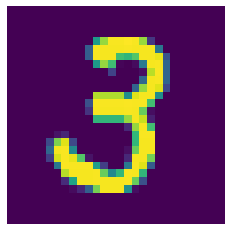

This is image from id: 6255


In [7]:
#show the test image
show_image(idx, test_images)
print("This is image from id:", idx)

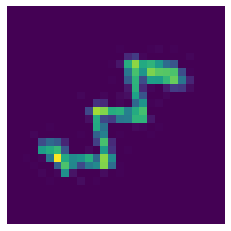

In [9]:
#im = scipy.misc.imread(os.path.join("out", image_file))
#im = input_s[0]
#show_image(0, input_s)

INFO:tensorflow:Restoring parameters from model/model.ckpt


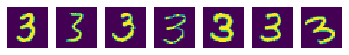

retrieved ids: [5497 8880 1941 4736 9766 5011 9592]


In [8]:
#run the test image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/model.ckpt")
    search_feat = sess.run(net, feed_dict={img_placeholder:[im]})
    
#calculate the cosine similarity and sort
dist = cdist(train_feat, search_feat, 'cosine') #cdist 计算两个输入集合的距离
rank = np.argsort(dist.ravel())  #np.argsort 将x中的元素从小到大排列，提取其对应的index(索引)

#show the top n similar image from train data
n = 7
show_image(rank[:n], train_images)
print("retrieved ids:", rank[:n])

In [ ]:
#liwei add new 
from PIL import Image
def img_transpose(image_path):
    # 读取图片转成灰度格式
    img = Image.open(image_path).convert('L')
    
    # resize的过程
    if img.size[0] != 28 or img.size[1] != 28:
        img = img.resize((28, 28))
    
    # 暂存像素值的一维数组
    arr = []

    for i in range(28):
        for j in range(28):
            # mnist 里的颜色是0代表白色（背景），1.0代表黑色
            pixel = 1.0 - float(img.getpixel((j, i)))/255.0
            # pixel = 255.0 - float(img.getpixel((j, i))) # 如果是0-255的颜色值
            arr.append(pixel)

    arr1 = np.array(arr).reshape((1, 28, 28, 1))
    #print(str(arr1[0].shape))
    return arr1[0]


num=1000
input_s = np.zeros((num,28,28,1))
output_s = np.random.rand(num,1)

i = 0
for root, dirs, files in os.walk("data/"):
    for file in files:
        input_s[i] = img_transpose("data/" + file)
        i = i+1
        
        
        